<a href="https://colab.research.google.com/github/MWFK/Time_Series_and_Sequence_with_TensorFlow/blob/main/2-Windowed_DNN(synthetic_data).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tf-nightly-2.0-preview


ERROR: Could not find a version that satisfies the requirement tf-nightly-2.0-preview (from versions: none)
ERROR: No matching distribution found for tf-nightly-2.0-preview


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0-rc4


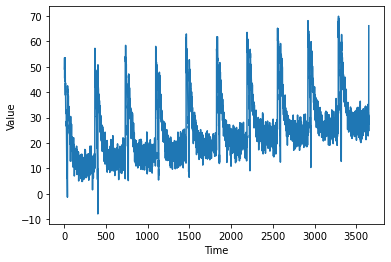

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32") # 10 years worth of data points 3651
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000 # In the previous notebook, we have used 1100 as a split itme, since we were working with only four years worth of data
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20 # Almost one month, we're going to use it as a feature, to predict the next value, which will be our label
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [ ]:
# We take a window of the data and we train an ML model to predict next value
# Feature is input; label is output; A feature is one column of the data in your input set.
# Once you've trained your model, you will give it sets of new input containing those features; it will return the predicted "label".
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  # from_tensors combines the input and returns a dataset with a single element:# [[1, 2], [3, 4]]
  # from_tensor_slices creates a dataset with a separate element for each row of the input tensor: # [1, 2], [3, 4]
  
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) # Window the data into chunks of five items whith a shift of one each time, and drop reminder to eliminate the shorter five items
  #for window_dataset in dataset:
    #for val in window_dataset:
      #print(val.numpy(), end="")
    #print()
  
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))  # Use flat_map if you want to make sure that the order of the dataset stays the same. For example, to flatten a dataset of batches into a dataset of their elements:
  # https://www.tensorflow.org/api_docs/python/tf/data/Dataset#flat_map
  # Tensorflow prefers it's data to be in numpy format
  #for window_dataset in dataset:
    #print(window.numy())

  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1])) # Split the data into features and labels # All the columns except last, and the last column
    #for x,y in dataset :
      #print(x.numpy(),y.numpy())

  dataset = dataset.batch(batch_size).prefetch(1) # We'll be having 2 features and two labels
  #for x,y in dataset :
    #print("x = ", x.numpy())
    #print("y = ", y.numpy())

  return dataset

In [ ]:
# windowed DNN
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

# We can add the callback function and the optimizer function

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)


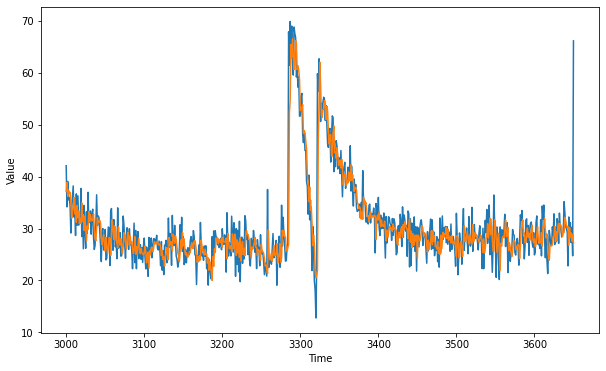

In [ ]:
forecast = []
# It's a forcasting, so we're comparing t with t+1, => window with next window
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis])) # Actual time until actual time + window_size, thus we're predicting value point one step aat a time
                                                                              # the [] that comes after numpy code defines the output shape
                                                                              # np.newaxis reshapes it to the input dimension that is used by the model

forecast = forecast[split_time - window_size:] # the last value: 2980 till the end, we don't get in the for loop, because it's shifted
results = np.array(forecast)[:,0,0] # without [:, 0, 0], the conversion is not possible
                                    # [:, 0] => [26.124496][28.934755][28.08256 ][24.812714]
                                    # [:, 0, 0] => 26.124496 28.934755 28.08256 24.812714

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

3.053427

In [ ]:
forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]
print(results)

IndexError: ignored

In [ ]:
print(forecast)

[array([[37.157524]], dtype=float32), array([[38.899464]], dtype=float32), array([[36.18614]], dtype=float32), array([[37.393547]], dtype=float32), array([[36.765423]], dtype=float32), array([[36.942993]], dtype=float32), array([[35.04157]], dtype=float32), array([[31.996273]], dtype=float32), array([[33.208187]], dtype=float32), array([[34.210186]], dtype=float32), array([[35.975323]], dtype=float32), array([[32.800056]], dtype=float32), array([[34.06125]], dtype=float32), array([[31.176159]], dtype=float32), array([[34.434216]], dtype=float32), array([[32.077885]], dtype=float32), array([[33.35684]], dtype=float32), array([[30.900688]], dtype=float32), array([[31.914967]], dtype=float32), array([[31.012918]], dtype=float32), array([[34.931137]], dtype=float32), array([[31.386196]], dtype=float32), array([[32.64439]], dtype=float32), array([[29.62254]], dtype=float32), array([[32.372707]], dtype=float32), array([[30.03479]], dtype=float32), array([[27.693237]], dtype=float32), array([

In [ ]:
print(results)

[[37.157524]
 [38.899464]
 [36.18614 ]
 [37.393547]
 [36.765423]
 [36.942993]
 [35.04157 ]
 [31.996273]
 [33.208187]
 [34.210186]
 [35.975323]
 [32.800056]
 [34.06125 ]
 [31.176159]
 [34.434216]
 [32.077885]
 [33.35684 ]
 [30.900688]
 [31.914967]
 [31.012918]
 [34.931137]
 [31.386196]
 [32.64439 ]
 [29.62254 ]
 [32.372707]
 [30.03479 ]
 [27.693237]
 [30.486225]
 [29.862806]
 [33.244774]
 [31.302917]
 [32.699677]
 [31.846682]
 [31.469282]
 [31.736103]
 [32.831802]
 [30.093012]
 [28.147156]
 [27.648144]
 [30.081526]
 [32.131203]
 [31.103054]
 [31.246796]
 [31.557858]
 [31.030796]
 [28.007973]
 [26.90203 ]
 [28.267424]
 [28.830257]
 [26.814112]
 [25.691011]
 [28.279287]
 [26.46236 ]
 [25.210434]
 [26.535122]
 [28.26273 ]
 [28.087809]
 [24.807058]
 [28.963768]
 [31.697136]
 [29.936466]
 [27.887718]
 [30.51861 ]
 [30.156273]
 [27.87026 ]
 [27.16546 ]
 [26.253376]
 [30.305279]
 [27.44324 ]
 [26.790867]
 [28.032549]
 [26.940119]
 [25.162138]
 [26.513454]
 [29.1906  ]
 [28.573738]
 [27.36776 ]